# Gaussian Mixture Models

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

w_1 = (2, 2)
sigma_1 = 0.7
P_1 = 2/3

w_2 = (1, 1)
sigma_2 = 0.2
P_2 = 1/3

def P(x, w_1=w_1, sigma_1=sigma_1, P_1=P_1, w_2=w_2, sigma_2=sigma_2, P_2=P_2):
    norm1 = multivariate_normal(mean=w_1, cov=sigma_1)
    norm2 = multivariate_normal(mean=w_2, cov=sigma_2)
    return norm1.pdf(x) * P_1 + norm2.pdf(x) * P_2

## Plot individual Gaussians and Mixture

Text(0.5, 1.0, 'Mixture of $P_{(x|1)}$ and $P_{(x|2)}$ with $P_1 = 0.67$ $P_2 = 0.33$')

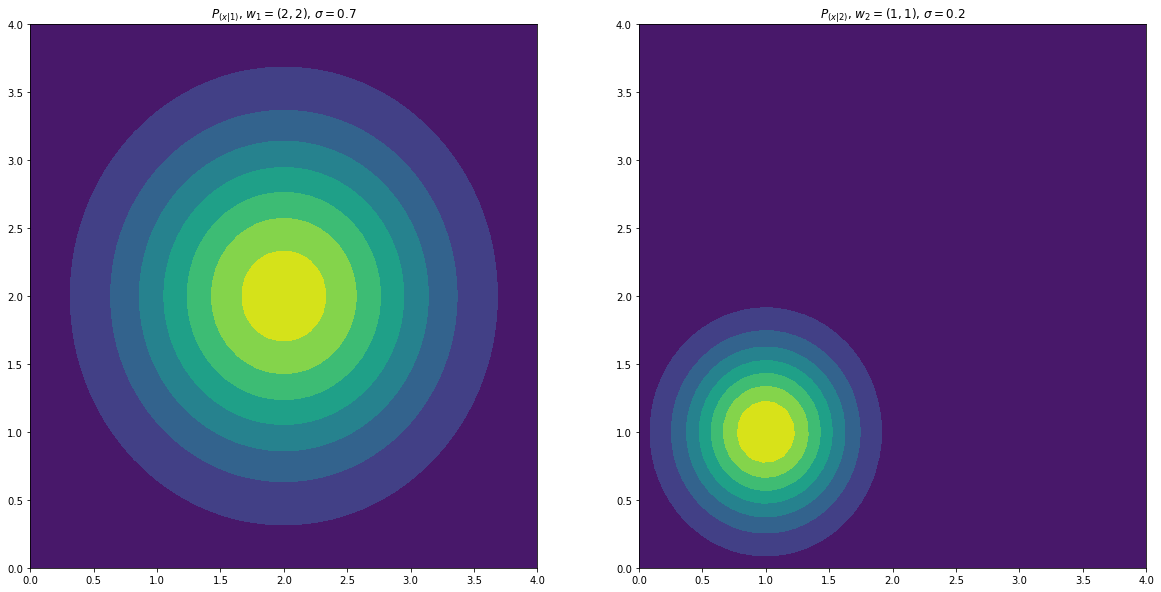

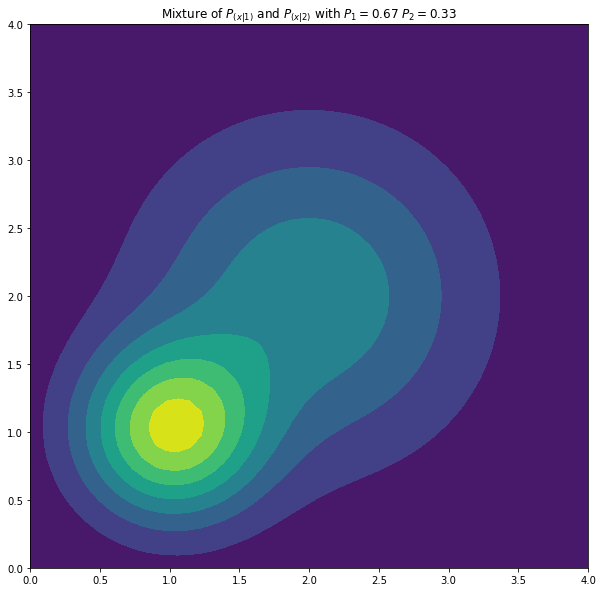

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

x = np.linspace(0, 4)
y = np.linspace(0, 4)
xv, yv = np.meshgrid(x, y)

norm1 = multivariate_normal(mean=w_1, cov=sigma_1)
norm2 = multivariate_normal(mean=w_2, cov=sigma_2)

xy = np.dstack((xv, yv))
zv1 = norm1.pdf(x=xy)
zv2 = norm2.pdf(x=xy)

ax = axes[0]
ax.contourf(xv, yv, zv1)
ax.set_title(f"$P_{{(x|1)}}$, $w_1 = {w_1}$, $\sigma = {sigma_1}$")
ax = axes[1]
ax.contourf(xv, yv, zv2)
ax.set_title(f"$P_{{(x|2)}}$, $w_2 = {w_2}$, $\sigma = {sigma_2}$")

fig, ax = plt.subplots(figsize=(10, 10))
zv3 = P(xy)
ax.contourf(xv, yv, zv3)
ax.set_title(f"Mixture of $P_{{(x|1)}}$ and $P_{{(x|2)}}$ with $P_1 = {P_1:.2f}$ $P_2 = {P_2:.2f}$")

## Generate data points

In [3]:
def sample_from_gaussian_mixture_2d(p, w_1=w_1, sigma_1=sigma_1, P_1=P_1, w_2=w_2, sigma_2=sigma_2, P_2=P_2):
    p = p
    N = 2

    U = np.random.uniform(size=p)

    X = np.zeros((N, p))

    for i in np.arange(p):
        if (U[i] < P_1):
            X[:,i] = np.random.multivariate_normal(w_1, np.diag([sigma_1, sigma_1]))
        else:
            X[:,i] = np.random.multivariate_normal(w_2, np.diag([sigma_2, sigma_2]))
    return X

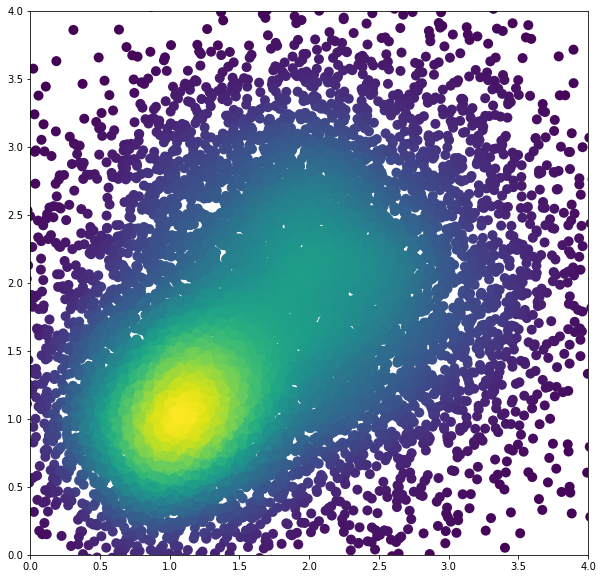

In [86]:
from scipy.stats import gaussian_kde
X = sample_from_gaussian_mixture_2d(p=10000)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

# Calculate the point density
z = gaussian_kde(X)(X)

ax.scatter(X[0], X[1], c=z, s=100, edgecolor='')

## Expectation Maximization

In [88]:
X = sample_from_gaussian_mixture_2d(p=10000)

In [89]:
def calculate_assignment_probabilities(X, w_old, var_old, P_old):
    N, p = X.shape
    M = w_old.shape[1]
    
    assignment_probs = np.zeros((M, p))
    for i in np.arange(p):
        x_i = X[:,i]

        P_x_i_given_components = np.zeros(M)
        for r in np.arange(M):
            w_r_old = w_old[:,r]
            var_r_old = var_old[r]
            P_r_old = P_old[r]
            P_x_i_given_r = multivariate_normal(mean=w_r_old, cov=var_r_old).pdf(x_i)
            P_x_i_given_components[r] = P_x_i_given_r * P_r_old
        P_x_i = P_x_i_given_components.sum()
        
        for q in np.arange(M):
            w_q_old = w_old[:,q]
            var_q_old = var_old[q]
            P_x_i_given_q = multivariate_normal(mean=w_q_old, cov=var_q_old).pdf(x_i)
            P_q_old = P_old[q]

            P_q_given_x_i = (P_x_i_given_q * P_q_old) / P_x_i

            assignment_probs[q, i] = P_q_given_x_i
    return assignment_probs


In [90]:
def calculate_w_new(X, assignment_probs):
    M = assignment_probs.shape[0]
    N, p = X.shape
    w_new = np.zeros((N, M))
    for q in np.arange(M):
        normalization = np.array([assignment_probs[q, i] for i in np.arange(p)]).sum()
        w_new[:,q] = np.array([assignment_probs[q, i] * X[:,i] for i in np.arange(p)]).T.sum(axis=1) / normalization
    return w_new

In [91]:
def calculate_var_new(X, w_old, assignment_probs):
    M = assignment_probs.shape[0]
    N, p = X.shape
    
    var_new = np.zeros((M))
    for q in np.arange(M):
        normalization = np.array([assignment_probs[q, i] for i in np.arange(p)]).sum()
        var_new[q] = (1/N) * np.array([(X[:,i] - w_old[:,q])**2 * assignment_probs[q,i] for i in np.arange(p)]).sum() / normalization
    return var_new

In [92]:
def calculate_P_new(X, assignment_probs):
    M = assignment_probs.shape[0]
    N, p = X.shape
    P_new = np.zeros((M))
    for q in np.arange(M):
        P_new[q] = (1/p) * np.array([assignment_probs[q, i] for i in np.arange(p)]).sum()
    return P_new

In [93]:
def calculate_new_params(X, w_old, assignment_probs):
    w_new = calculate_w_new(X, assignment_probs)
    var_new = calculate_var_new(X, w_old, assignment_probs)
    P_new = calculate_P_new(X, assignment_probs)
    return w_new, var_new, P_new

In [94]:
from scipy.spatial import distance_matrix

def gmm_em(X, P_0, w_0, var_0, tolerance=0.001):
    w_old = w_0.copy()
    var_old = var_0.copy()
    P_old = P_0.copy()
    
    diff_w = diff_var = diff_P = np.array([np.inf])
    while np.greater([diff_w, diff_var, diff_P], tolerance).any():
        assignment_probs = calculate_assignment_probabilities(X, w_old, var_old, P_old)
        
        w_new, var_new, P_new = calculate_new_params(X, w_old, assignment_probs)
        
        diff_w = distance_matrix(w_new.T, w_old.T)[0]
        diff_var = np.abs(var_new - var_old)
        diff_P = np.abs(P_new - P_old)
        
        w_old, var_old, P_old = w_new, var_new, P_new
    return w_old, var_old, P_old

In [ ]:
M = 2
N = 2
w_0 = np.array([[0, 3], [0, 3]])
var_0 = np.random.rand(M)
P_0 = np.array([1/M, 1/M])

w, var, P = gmm_em(X, P_0, w_0, var_0)

print("w:", w)
print("var:", var)
print("P:", P)

In [44]:
np.array([[0, 1], [0, 1]]).sum(axis=1)

array([1, 1])